# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install packages


In [ ]:
!pip install -q transformers
# !pip install -q tensorflow==2.2-rc1
!pip install -q tf-models-official==2.2.0

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

In [ ]:
!pip install keras-lr-multiplier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Keras-2.2.4-py2.py3-none-any.whl (312 kB)
  Attempting uninstall: Keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.2.4 which is incompatible.


In [ ]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-lr-multiplier 0.9.0 requires Keras==2.2.4, but you have keras 2.12.0 which is incompatible.


In [ ]:
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import libraries

In [ ]:
import os
import time
import datetime
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer, TFBertForSequenceClassification,AutoConfig
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Maximum,LayerNormalization,GlobalMaxPooling2D,Average,Dot, Dense, Input, GlobalAveragePooling1D, BatchNormalization, Activation, Concatenate, Flatten, Dropout, Conv1D, MaxPooling1D, Add, Lambda, GlobalAveragePooling2D, Reshape, RepeatVector, UpSampling1D
from tensorflow.keras.models import Model
from keras.layers import LSTM, Bidirectional
from official import nlp
import official.nlp.optimization


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Set seed value
seed_value = 56
os.environ['PYTHONHASHSEED']=str(0)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
# for later versions:
# tf.compat.v1.set_random_seed(seed_value)
# 5. Configure a new global `tensorflow` session
from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


# Parameters

In [ ]:
base_dir    = '/content/drive/MyDrive/Datasets/'
train_path  = os.path.join(base_dir, 'train-ekphrasis.csv')
test_path    = os.path.join(base_dir, 'test-ekphrasis.csv')
img_train_path = os.path.join(base_dir, 'img_train.npy')
img_val_path = os.path.join(base_dir, 'img_val.npy')
img_test_path = os.path.join(base_dir, 'img_test.npy')
MAX_LENGTH  = 256
MODEL       = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'
MODEL_NAME  = 'model'
N_LABELS    = 1

# Read data

In [ ]:
df_train = pd.read_csv(train_path)

In [ ]:
print(df_train.shape)

(14277, 9)


In [ ]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
 7   CleanText   14277 non-null  object
 8   enc_label   14277 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 1004.0+ KB
None


In [ ]:
display(df_train.head())

,tweetId,tweetText,userId,imageId(s),username,timestamp,label,CleanText,enc_label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake,Do you remember the movie: “The day after tomo...,1
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake,@milenagimon: Look at Sandy in NY! Tremendous ...,1
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake,"Good photo of Hurricane Sandy, it reminds me o...",1
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake,Scary shit #hurricane #NY http://t.co/e4JLBUfH,1
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake,My fave place in the world #nyc #hurricane #sa...,1


In [ ]:
df_test = pd.read_csv(test_path)

In [ ]:
print(df_test.shape)

(3755, 9)


In [ ]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
 7   CleanText   3755 non-null   object
 8   enc_label   3755 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 264.1+ KB
None


In [ ]:
display(df_test.head())

,tweetId,tweetText,userId,imageId(s),username,timestamp,label,CleanText,enc_label
0,578854927457349632,kereeen RT @Shyman33: Eclipse from ISS.... htt...,70824972,eclipse_01,peay_s,Fri Mar 20 09:45:43 +0000 2015,fake,kereeen RT @Shyman33: Eclipse from ISS.... htt...,1
1,578874632670953472,Absolutely beautiful! RT @Shyman33: Eclipse fr...,344707006,eclipse_01,JaredUcanChange,Fri Mar 20 11:04:02 +0000 2015,fake,Absolutely beautiful! RT @Shyman33: Eclipse fr...,1
2,578891261353984000,“@Shyman33: Eclipse from ISS.... http://t.co/C...,224839607,eclipse_01,tpjp1231,Fri Mar 20 12:10:06 +0000 2015,fake,“@Shyman33: Eclipse from ISS.... http://t.co/C...,1
3,578846612312748032,Eclipse from ISS.... http://t.co/En87OtvsU6,134543073,eclipse_01,Shyman33,Fri Mar 20 09:12:41 +0000 2015,fake,Eclipse from ISS.... http://t.co/En87OtvsU6,1
4,578975333841551360,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,1150728872,eclipse_01,Epimethee_,Fri Mar 20 17:44:11 +0000 2015,fake,@ebonfigli: Eclipse seen from the ISS... Anoth...,1


In [ ]:
df_train.drop(labels=['tweetId','userId', 'username', 'timestamp'], axis = 'columns', inplace = True)
df_test.drop(labels=['tweetId','userId', 'username', 'timestamp'], axis = 'columns', inplace = True)
df_train.rename(columns = {"imageId(s)":"images"}, inplace = True)
df_test.rename(columns = {"imageId(s)":"images"}, inplace = True)

In [ ]:
df_train.replace({'images': {'sandyB_real_4': 'sandyB_real_04'}}, inplace = True)
df_train.replace({'images': {'sandyB_real_6': 'sandyB_real_60'}}, inplace = True)

In [ ]:
df_test.drop(df_test[df_test.images =="syrian_boy_video"].index, inplace = True)
df_test.drop(df_test[df_test.images =="varoufakis_video"].index, inplace = True)
df_test.drop(df_test[df_test.images =="eclipse_video_01 "].index, inplace = True)

In [ ]:
missing_media_train = ["boston_fake_35", "boston_real_05","sochi_fake_1fake"]
for i in range(len(df_train.images)):
    image = df_train['images'][i]
    for j in image.split(sep = ','):
        if j in missing_media_train:
            df_train.drop(i, axis=0, inplace=True)

In [ ]:
# Get the lists of sentences and their labels.
train_sent      = df_train.CleanText.values
train_labels    = df_train.enc_label.values
test_sent        = df_test.CleanText.values
test_labels      = df_test.enc_label.values

In [ ]:
df_train.head()

,tweetText,images,label,CleanText,enc_label
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,fake,Do you remember the movie: “The day after tomo...,1
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,fake,@milenagimon: Look at Sandy in NY! Tremendous ...,1
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,fake,"Good photo of Hurricane Sandy, it reminds me o...",1
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,fake,Scary shit #hurricane #NY http://t.co/e4JLBUfH,1
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,fake,My fave place in the world #nyc #hurricane #sa...,1


In [ ]:
df_test.head()

,tweetText,images,label,CleanText,enc_label
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,eclipse_01,fake,kereeen RT @Shyman33: Eclipse from ISS.... htt...,1
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,eclipse_01,fake,Absolutely beautiful! RT @Shyman33: Eclipse fr...,1
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,eclipse_01,fake,“@Shyman33: Eclipse from ISS.... http://t.co/C...,1
3,Eclipse from ISS.... http://t.co/En87OtvsU6,eclipse_01,fake,Eclipse from ISS.... http://t.co/En87OtvsU6,1
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,eclipse_01,fake,@ebonfigli: Eclipse seen from the ISS... Anoth...,1


In [ ]:
#Bertweet tokens
import re

for i in range(train_sent.shape[0]):
  train_sent[i] = re.sub(r'<url>','HTTPURL',train_sent[i])
  train_sent[i] = re.sub(r'<user>','@USER',train_sent[i])
for i in range(test_sent.shape[0]):
  test_sent[i] = re.sub(r'<url>','HTTPURL',test_sent[i])
  test_sent[i] = re.sub(r'<user>','@USER',test_sent[i])

In [ ]:
#train_df, val_df = train_test_split(df_train, test_size=0.2, random_state = 0)

In [ ]:
"""
train_sent      = train_df.CleanText.values
train_labels    = train_df.enc_label.values

val_sent      = val_df.CleanText.values
val_labels    = val_df.enc_label.values

test_sent        = df_test.CleanText.values
test_labels      = df_test.enc_label.values
"""

In [ ]:
#Bertweet tokens
"""
import re

for i in range(train_sent.shape[0]):
  train_sent[i] = re.sub(r'<url>','HTTPURL',train_sent[i])
  train_sent[i] = re.sub(r'<user>','@USER',train_sent[i])


for i in range(val_sent.shape[0]):
  val_sent[i] = re.sub(r'<url>','HTTPURL',val_sent[i])
  val_sent[i] = re.sub(r'<user>','@USER',val_sent[i])


for i in range(test_sent.shape[0]):
  test_sent[i] = re.sub(r'<url>','HTTPURL',test_sent[i])
  test_sent[i] = re.sub(r'<user>','@USER',test_sent[i])
  """

In [ ]:
#train_sent = np.append(train_sent,val_sent)
#train_labels = np.append(train_labels,val_labels)

In [ ]:
print(len(train_sent), len(train_labels))
#print(len(val_sent), len(val_labels))
print(len(test_sent), len(test_labels))

14175 14175
3753 3753


In [ ]:
img_train = np.load(img_train_path)
img_val = np.load(img_val_path)
img_test = np.load(img_test_path)
img_train.shape,  img_test.shape, img_val.shape

((11340, 224, 224, 3), (3753, 224, 224, 3), (2835, 224, 224, 3))

In [ ]:
img_train = np.vstack((img_train,img_val))
img_train.shape

In [ ]:
print(len(train_sent), len(train_labels))
print(len(test_sent), len(test_labels))

14175 14175
3753 3753


In [ ]:
len(train_sent)

14175

# Tokenization & Input Formatting


In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234911 sha256=9fcf44427e3ae591a70892a29e0731e8893e5113248105b9e9f900fc1b080083
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji


In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(MODEL, do_lower_case=False)

Loading BERT tokenizer...


In [ ]:
print(' Original: ', train_sent[4])
print('Tokenized: ', tokenizer.tokenize(train_sent[4]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sent[4])))

 Original:  My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽 http://t.co/Ex61doZk
Tokenized:  ['My', 'Ġf', 'ave', 'Ġplace', 'Ġin', 'Ġthe', 'Ġworld', 'Ġ#', 'ny', 'c', 'Ġ#', 'hur', 'ricane', 'Ġ#', 's', 'andy', 'Ġ#', 'stat', 'ue', 'of', 'liber', 'ty', 'ĠðŁ', 'Ĺ', '½', 'Ġhttp', '://', 't', '.', 'co', '/', 'Ex', '61', 'do', 'Z', 'k']
Token IDs:  [2387, 856, 4097, 317, 11, 5, 232, 849, 2855, 438, 849, 14898, 33280, 849, 29, 10708, 849, 24344, 1780, 1116, 39176, 2553, 8103, 6800, 10809, 2054, 640, 90, 4, 876, 73, 9089, 5606, 5016, 1301, 330]


## Find max length

In [ ]:
max_len = 0
stat = []
for sent in tqdm(train_sent):
    input_ids   = tokenizer.encode(sent, add_special_tokens=True)
#    if(len(input_ids)>96):
#      print(sent)
    max_len     = max(max_len, len(input_ids))
    stat.append(len(input_ids))

print('\nMax sentence length in train data: ', max_len)

# for sent in tqdm(val_sent):
#     input_ids   = tokenizer.encode(sent, add_special_tokens=True)
#  #   if(len(input_ids)>96):
#  #     print(sent)
#     max_len     = max(max_len, len(input_ids))
#     stat.append(len(input_ids))

# print('\nMax sentence length in both train and val data: ', max_len)

for index,sent in tqdm(enumerate(test_sent)):
   input_ids   = tokenizer.encode(sent, add_special_tokens=True)
   if(len(input_ids)>96):
     print(index, sent)
   max_len     = max(max_len, len(input_ids))
   stat.append(len(input_ids))

print('\nMax sentence length in both train and val data: ', max_len)

  0%|          | 0/14175 [00:00<?, ?it/s]


Max sentence length in train data:  2437


0it [00:00, ?it/s]

1846 @Austynzogs: The historic Dharahara tower, a landmark in Nepal's capital collapsed during a 7.8 magnitude earthquake http://t.co/owF6NJHbk6 378809160 nepal_25 Gidi_Traffic Sat Apr 25 18:32:02 +0000 2015 real 591988110356910081 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a la... http://t.co/0xV9Ia2WQr #mashable 2499901884 nepal_25 jamsmith54 Sat Apr 25 15:32:18 +0000 2015 real 591987485816721408 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/B2KC7V9Jbr 1619859326 nepal_25 SSMAAds Sat Apr 25 15:29:49 +0000 2015 real 591987634530099202 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/Y7XXWjYJcK 3187243479 nepal_25 JiggySNE Sat Apr 25 15:30:25 +0000 2015 real 591987586610135041 Nepal's historic Dharahara Tower collapses in massive earthquake. http://t.co/xjxJyGK60S http://t.co/FN6

## Tokenize

### Train

In [ ]:
input_ids       = []
attention_masks = []

for sent in tqdm(train_sent):
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = MAX_LENGTH,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'np',
                        truncation = True,
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


id_train        = np.concatenate(input_ids)
mask_train      = np.concatenate(attention_masks)
y_train         = train_labels
id_train.shape, mask_train.shape, y_train.shape

  0%|          | 0/14175 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


((14175, 32), (14175, 32), (14175,))

## Create iterator for data

In [ ]:
BATCH_SIZE      = 32

X_train         = [
    id_train,
    mask_train,
    img_train
]


# Train TFBertForSequenceClassification Model

In [ ]:
from tensorflow.keras.applications.regnet import RegNetY032                                  #Change here for different models
from tensorflow.keras.applications.regnet import preprocess_input                 #Change here for different models

def create_cnn(input_shape):
  inputs = Input(shape=input_shape)
  x = Lambda(preprocess_input)(inputs)
  # load the VGG16 network, ensuring the head FC layer sets are left
  # off                                                                           - Change here for different models
  baseModel = RegNetY032(weights="imagenet", include_top=True, input_tensor=x)

  # construct the head of the model that will be placed on top of the
  # the base model
  headModel_cnn = baseModel.layers[22].output
  headModel_fc  = baseModel.layers[25].output
  ###Attention
  headModel_cnn = Reshape((-1,headModel_cnn.shape[-1]))(headModel_cnn)

  ###Non-attention
  # headModel = Flatten()(headModel)
  # headModel = Dense(512)(headModel)
  # headModel = BatchNormalization()(headModel)
  # headModel = Activation("relu")(headModel)
  # headModel = Dropout(0.2)(headModel)

  # headModel = Dense(512)(headModel)
  # headModel = BatchNormalization()(headModel)
  # headModel = Activation("relu")(headModel)
  # headModel = Dropout(0.2)(headModel)

  model = Model(inputs=baseModel.input, outputs=[headModel_cnn, headModel_fc])

  # loop over all layers in the base model and freeze them so they will
  # *not* be updated during the first training process
  for layer in baseModel.layers:
    layer.trainable = False

  return model


In [ ]:
def create_model(transformer, max_len=256):
    merge = []

    input_ids           = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask      = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')
    image               = create_cnn((224,224,3))
    sequence_output_1     = transformer(input_ids, attention_mask=attention_mask)[2][-1]
    sequence_output_2     = transformer(input_ids, attention_mask=attention_mask)[2][-2]
    sequence_output_3     = transformer(input_ids, attention_mask=attention_mask)[2][-3]
    sequence_output_4     = transformer(input_ids, attention_mask=attention_mask)[2][-4]
    sequence_output       = Concatenate(axis=2)([sequence_output_1, sequence_output_2, sequence_output_3, sequence_output_4])

   #cls_token           = sequence_output[:, 0, :]

    #merge.append(cls_token)

   # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [2,3,4,5]
    size_pool = 3
    drop_rate = 0.2
    final_hid = 32

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=768, kernel_size=filter_size)(sequence_output)
        l_conv = BatchNormalization()(l_conv)
        l_conv = Activation('relu')(l_conv)
        # l_pool = MaxPooling1D(pool_size=max_len-filter_size+1)(l_conv)
        l_pool = MaxPooling1D(pool_size=size_pool)(l_conv)
        convs.append(l_pool)
        #merge.append(Flatten()(l_pool))

    l2_pool = Concatenate(axis=1)(convs)
    # l2_pool = BatchNormalization()(l2_pool)
    for _ in range(2):
        origin  = l2_pool
        l2_conv = Conv1D(filters=768, kernel_size=size_pool,padding='same')(l2_pool)
        l2_conv = BatchNormalization()(l2_conv)
        l2_conv = Activation('relu')(l2_conv)
        #print(origin.shape, l2_conv.shape)
        # l2_conv = Add()([Lambda(lambda x: x[0]*x[1])([origin,0.1]), l2_conv])
        l2_pool = MaxPooling1D(pool_size=size_pool)(l2_conv)

    text = Flatten()(l2_pool)
    #append to merge
    text_append = Dense(512)(text)
    text_append = BatchNormalization()(text_append)
    text_append = Activation('relu')(text_append)
    text_append = Dropout(drop_rate)(text_append)
    text_append = Dense(final_hid)(text_append)
    text_append = BatchNormalization()(text_append)
    text_append = Activation('relu')(text_append)

    # merge.append(text_append)
    # text_append = l2_pool

    #text for attention
    # text = Dropout(0.2)(text)
    # text = Dense(128)(text)
    # text = BatchNormalization()(text)
    # text = Activation("tanh")(text)                  #change to tanh?
    # text = Dropout(0.2)(text)
    image_append = Dense(2048)(image.output[1])
    image_append = BatchNormalization()(image_append)
    image_append = Activation('relu')(image_append)
    image_append = Dropout(drop_rate)(image_append)
    image_append = Dense(final_hid)(image_append)
    image_append = BatchNormalization()(image_append)
    image_append = Activation('relu')(image_append)

    img = Dense(final_hid)(image.output[0])
    img = BatchNormalization()(img)
    img = Activation('relu')(img)


    # image_append = image.output[1]
    # merge.append(image_append)
    # image_append = image.output[0]

    ## Self Attention Mechanism
    head = 1
    att_layers = 1
    att_hid = 32
    ##With attention - text on image
    inpAttImg_key = img
    inpAttImg_query = text_append
    for layer in range(1):
      att_img = []
      concat_key = []
      for _ in range(head):
        img_key = Dense(att_hid/head, use_bias=False)(inpAttImg_key) #change to tanh?
        text_query = Dense(att_hid/head, use_bias=False)(inpAttImg_query)
        # img_key = BatchNormalization()(img_key)
        # img_key = Activation('tanh')(img_key)
        # text_query = BatchNormalization()(text_query)
        # text_query = Activation('tanh')(text_query)

        img_value = Dense(att_hid/head, use_bias=False)(inpAttImg_key)
        # img_value = BatchNormalization()(img_value)
        # img_value = Activation('tanh')(img_value)

        attention = Dot(axes=(1,2))([text_query, img_key])
        attention = Lambda(lambda x: x[0]/x[1])([attention,np.sqrt(att_hid/head)])
        attention = Activation("softmax")(attention)
        head_att_img = Dot(axes=(1,1))([attention, img_value])
        att_img = head_att_img
        concat_key = img_key
      # att_img = Concatenate(axis=1)(att_img)
      # att_img = Dense(512, use_bias=False)(att_img)
      # att_img = Dropout(0.3)(att_img)
      # att_img = Add()([att_img, inpAttImg_query])
      # att_img = LayerNormalization()(att_img)
      # att_img2 = Dense(1024,activation='relu')(att_img)
      # att_img2 = Dense(512)(att_img)
      # att_img2 = Dropout(0.1)(att_img2)
      # att_img = Add()([att_img, att_img2])
      # att_img = LayerNormalization()(att_img)
      att_img2 = Average()([ Activation('relu')(BatchNormalization()(Dense(final_hid)(att_img))),
                             Activation('relu')(BatchNormalization()(Dense(final_hid)(att_img))),
                             Activation('relu')(BatchNormalization()(Dense(final_hid)(att_img))),
                             Activation('relu')(BatchNormalization()(Dense(final_hid)(att_img)))])
      att_img2 = Dense(final_hid)(att_img2)
      att_img2 = BatchNormalization()(att_img2)
      att_img2 = Activation('relu')(att_img2)
      att_img2 = Dropout(drop_rate)(att_img2)
      att_img = Add()([inpAttImg_query, att_img2])
      att_img = LayerNormalization()(att_img)



      # concat_key = Concatenate(axis=1)(concat_key)
      # concat_key = Dense(512)(concat_key)
      # concat_key = Dropout(0.3)(inpAttImg_key)
      # concat_key = Add()([concat_key, inpAttImg_key])
      # concat_key = LayerNormalization()(concat_key)
      # concat_key2 = Dense(1024,activation='relu')(concat_key)
      # concat_key2 = Dense(512)(concat_key)
      # concat_key2 = Dropout(0.1)(concat_key2)
      # concat_key = Add()([concat_key, concat_key2])
      # concat_key = LayerNormalization()(concat_key)

      inpAttImg_query = att_img
      inpAttImg_key = concat_key

    # merge.append(att_img)

    ##attention image on text
    inpAttText_key = l2_pool
    inpAttText_query = image_append
    for layer in range(1):
      att_text = []
      concat_key = []
      for _ in range(head):
        img_query = Dense(att_hid/head, use_bias=False)(inpAttText_query)
    #     # # img_query = BatchNormalization()(img_query)
    #     # # img_query = Activation('tanh')(img_query)
        text_key = Dense(att_hid/head, use_bias=False)(inpAttText_key)
    #     # # text_key = BatchNormalization()(text_key)
    #     # # text_key = Activation('tanh')(text_key)
        text_value = Dense(att_hid/head, use_bias=False)(inpAttText_key)
        attention = Dot(axes=(1,2))([img_query, text_key])
        attention = Lambda(lambda x: x[0]/x[1])([attention,np.sqrt(att_hid/head)])
        attention = Activation("softmax")(attention)
        head_att_text = Dot(axes=(1,1))([attention, text_value])
        att_text = head_att_text
        concat_key = text_key
      # att_text = Concatenate(axis=1)(att_text)
      # att_text = Dense(512, use_bias=False)(att_text)
      # att_text = Dropout(0.3)(att_text)
      # att_text = Add()([att_text, inpAttText_query])
      # att_text = LayerNormalization()(att_text)
      # att_text2 = Dense(1024,activation='relu')(att_text)
      # att_text2 = Dense(512)(att_text)
      # att_text2 = Dropout(0.1)(att_text2)
      # att_text = Add()([att_text, att_text2])
      # att_text = LayerNormalization()(att_text)

      # concat_key = Concatenate(axis=1)(concat_key)
      # concat_key = Dense(512)(concat_key)
      # concat_key = Dropout(0.3)(concat_key)
      # concat_key = Add()([concat_key, inpAttText_key])
      # concat_key = LayerNormalization()(concat_key)
      # concat_key2 = Dense(1024,activation='relu')(concat_key)
      # concat_key2 = Dense(512)(concat_key)
      # concat_key2 = Dropout(0.1)(concat_key2)
      # concat_key = Add()([concat_key, concat_key2])
      # concat_key = LayerNormalization()(concat_key)
      att_text2 = Average()([Activation('relu')(BatchNormalization()(Dense(final_hid)(att_text))),
                             Activation('relu')(BatchNormalization()(Dense(final_hid)(att_text))),
                             Activation('relu')(BatchNormalization()(Dense(final_hid)(att_text))),
                             Activation('relu')(BatchNormalization()(Dense(final_hid)(att_text)))])
      att_text2 = Dense(final_hid)(att_text2)
      att_text2 = BatchNormalization()(att_text2)
      att_text2 = Activation('relu')(att_text2)
      att_text2 = Dropout(drop_rate)(att_text2)
      att_text = Add()([inpAttText_query, att_text2])
      att_text = LayerNormalization()(att_text)

      inpAttText_query = att_text
      inpAttText_key = concat_key

    head = 1
    ###Self attention image
    inpAttSelf_key = img
    inpAttSelf_query = img
    for layer in range(att_layers):
      self_img = []
      for _ in range(head):
        self_query = Dense(att_hid/head, use_bias=False)(inpAttSelf_query)
        self_key = Dense(att_hid/head, use_bias=False)(inpAttSelf_key)
        self_value = Dense(att_hid/head, use_bias=False)(inpAttSelf_key)

        attention = Dot(axes=(2,2))([self_query, self_key])
        attention = Lambda(lambda x: x[0]/x[1])([attention,np.sqrt(att_hid/head)])
        attention = Activation("softmax")(attention)
        head_att_self = Dot(axes=(2,1))([attention, self_value])
        self_img = head_att_self

      # self_img = Concatenate(axis=2)(self_img)
      # self_img = Dense(512, use_bias=False)(self_img)
      # self_img = Dropout(0.3)(self_img)
      # self_img = Add()([self_img, inpAttSelf_query])
      # self_img = LayerNormalization()(self_img)
      # self_img2 = Dense(1024,activation='relu')(self_img)
      # self_img2 = Dense(512)(self_img2)
      # self_img2 = Dropout(0.3)(self_img2)
      # self_img = Add()([self_img, self_img2])
      # self_img = LayerNormalization()(self_img)
      self_img2 = Average()([Activation('relu')(BatchNormalization()(Dense(final_hid)(self_img))),
                             Activation('relu')(BatchNormalization()(Dense(final_hid)(self_img))),
                             Activation('relu')(BatchNormalization()(Dense(final_hid)(self_img))),
                             Activation('relu')(BatchNormalization()(Dense(final_hid)(self_img)))])
      self_img2 = Dense(final_hid)(self_img2)
      self_img2 = BatchNormalization()(self_img2)
      self_img2 = Activation('relu')(self_img2)
      self_img2 = Dropout(drop_rate)(self_img2)
      self_img = Add()([inpAttSelf_query, self_img2])
      self_img = LayerNormalization()(self_img)

      inpAttSelf_query = self_img
      inpAttSelf_key = self_img


    # merge.append(att_text)
    self_img =  Flatten()(self_img)
    # att_img =  Dense(32)(Flatten()(att_img))
    # # # att_img = BatchNormalization()(att_img)
    # att_img = Activation('relu')(att_img)

    # att_text = Flatten()(att_text)
    # # # att_text = Concatenate(axis=1)([att_text,self_img])
    # att_text = Dense(32)(att_text)
    # # # att_text = BatchNormalization()(att_text)
    # att_text = Activation('relu')(att_text)

    self_img =  Dense(final_hid)(self_img)
    self_img = BatchNormalization()(self_img)
    self_img = Activation('relu')(self_img)

    # self_img =  Dense(32)(self_img)
    # # # self_img = BatchNormalization()(self_img)
    # self_img = Activation('relu')(self_img)

    # text_append =  Dense(512)(Flatten()(text_append))
    # text_append = BatchNormalization()(text_append)
    # text_append = Activation('relu')(text_append)

    # image_append =  Dense(512)(Flatten()(image_append))
    # image_append = BatchNormalization()(image_append)
    # image_append = Activation('relu')(image_append)

    # merge.append(att_img)
    # merge.append(att_text)
    merge.append(self_img)

    # merge.append(Dense(512,activation='relu')(Flatten()(self_img)))
    # merge.append(text_append)
    merge.append(image_append)
    l_merge             = Concatenate(axis=1)(merge)
    # l_merge = image_append
    l_merge = Dropout(drop_rate)(l_merge)
    l_merge = Dense(final_hid)(l_merge)
    l_merge = BatchNormalization()(l_merge)
    l_merge = Activation('relu')(l_merge)
    l_merge = Dropout(drop_rate)(l_merge)
    # l_merge             = Average()(merge)
    out                 = Dense(N_LABELS, activation='sigmoid')(l_merge)
    model               = Model(inputs=[input_ids, attention_mask, image.input],
                            outputs=out)
    return model

In [ ]:
%%time
EPOCHS          = 15
total_steps     = len(y_train) * BATCH_SIZE
train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / BATCH_SIZE) + 1
num_train_steps = steps_per_epoch * EPOCHS
warmup_steps    = int(steps_per_epoch * 1)
#warmup_steps    = 0

# Create the learning rate scheduler.
decay_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=1e-4,
      decay_steps=num_train_steps,
      end_learning_rate=0)

warmup_schedule = nlp.optimization.WarmUp(
        initial_learning_rate=7e-5,
        decay_schedule_fn=decay_schedule,
        warmup_steps=warmup_steps)

optimizer       = nlp.optimization.AdamWeightDecay(
        learning_rate=warmup_schedule,
        epsilon=1e-8,
        exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])

#Load bert4news
# config = AutoConfig.from_pretrained('/content/drive/MyDrive/bert4news/config.json')
# transformer = TFAutoModel.from_pretrained('/content/drive/MyDrive/bert4news/pytorch_model.bin', from_pt=True, config=config)

transformer = TFAutoModel.from_pretrained(MODEL,output_attentions=False,output_hidden_states=True,return_dict =True)
transformer.trainable = False
model = create_model(transformer, max_len=MAX_LENGTH)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                loss='binary_crossentropy',
                metrics='accuracy')

model.summary()

Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


574710816/574710816 [==============================] - 5s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['lambda[0][0]']                 
                                )                                                                 
                         

## Train model

In [ ]:
from keras.utils import np_utils
from keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import f1_score
from sklearn.datasets import make_classification

class roc_auc_callback(Callback):
    def __init__(self,training_data):#,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        #self.x_val = validation_data[0]
        #self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return


    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [ ]:
n_steps = int(np.ceil(y_train.shape[0] / BATCH_SIZE))

# Checkpoint path
ckpt_path     = f'/content/drive/My Drive/mediaeval2016/checkpoint-test/{MODEL_NAME}/'
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)
ckpt_path     += 'cp-{epoch:02d}.h5'

# Callback
my_callbacks  = [tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path,
                                                    #monitor='val_loss',
                                                    save_weights_only=True,
                                                    save_freq='epoch'),
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                 roc_auc_callback(training_data=(X_train, y_train))]#,validation_data=(X_test_data, test_labels))]

H = model.fit(
    X_train, y_train,
    #validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    #steps_per_epoch=n_steps,
    # class_weight=class_weights,
    shuffle=False,
    callbacks=my_callbacks
)

Epoch 1/15
443/443 [==============================] - ETA: 0s - loss: 0.5944 - accuracy: 0.7043

443/443 [==============================] - 108s 198ms/step - loss: 0.5944 - accuracy: 0.7043
Epoch 2/15
443/443 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.7256

443/443 [==============================] - 83s 187ms/step - loss: 0.5404 - accuracy: 0.7256
Epoch 3/15
443/443 [==============================] - ETA: 0s - loss: 0.4966 - accuracy: 0.7551

443/443 [==============================] - 83s 186ms/step - loss: 0.4966 - accuracy: 0.7551
Epoch 4/15
443/443 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.7856

443/443 [==============================] - 82s 186ms/step - loss: 0.4488 - accuracy: 0.7856
Epoch 5/15
443/443 [==============================] - ETA: 0s - loss: 0.4062 - accuracy: 0.8205

443/443 [==============================] - 82s 185ms/step - loss: 0.4062 - accuracy: 0.8205
Epoch 6/15
443/443 [==============================] - ETA: 0s - loss: 0.3554 - accuracy: 0.8564

443/443 [==============================] - 82s 186ms/step - loss: 0.3554 - accuracy: 0.8564
Epoch 7/15
443/443 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.8892

443/443 [==============================] - 83s 186ms/step - loss: 0.3127 - accuracy: 0.8892
Epoch 8/15
443/443 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.9138

443/443 [==============================] - 83s 186ms/step - loss: 0.2679 - accuracy: 0.9138
Epoch 9/15
443/443 [==============================] - ETA: 0s - loss: 0.2328 - accuracy: 0.9302

443/443 [==============================] - 82s 186ms/step - loss: 0.2328 - accuracy: 0.9302
Epoch 10/15
443/443 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.9436

443/443 [==============================] - 85s 191ms/step - loss: 0.2018 - accuracy: 0.9436
Epoch 11/15
443/443 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.9547

443/443 [==============================] - 83s 187ms/step - loss: 0.1742 - accuracy: 0.9547
Epoch 12/15
443/443 [==============================] - ETA: 0s - loss: 0.1624 - accuracy: 0.9575

443/443 [==============================] - 83s 186ms/step - loss: 0.1624 - accuracy: 0.9575
Epoch 13/15
443/443 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.9619

443/443 [==============================] - 82s 185ms/step - loss: 0.1459 - accuracy: 0.9619
Epoch 14/15
443/443 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.9620

443/443 [==============================] - 83s 187ms/step - loss: 0.1393 - accuracy: 0.9620
Epoch 15/15
443/443 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.9653

443/443 [==============================] - 83s 188ms/step - loss: 0.1279 - accuracy: 0.9653


# Saving Fine-Tuned Model

In [ ]:
model.save_weights(os.path.join(base_dir, f'{MODEL_NAME}.h5'))

In [ ]:
EPOCHS = 15

In [ ]:
%%time
EPOCHS          = EPOCHS
total_steps     = len(y_train) * BATCH_SIZE
train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / BATCH_SIZE) + 1
num_train_steps = steps_per_epoch * EPOCHS
# warmup_steps    = int(num_train_steps * 0.1)
warmup_steps    = 0

# Create the learning rate scheduler.
decay_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=2e-5,
      decay_steps=num_train_steps,
      end_learning_rate=0)

warmup_schedule = nlp.optimization.WarmUp(
        initial_learning_rate=2e-5,
        decay_schedule_fn=decay_schedule,
        warmup_steps=warmup_steps)

optimizer       = nlp.optimization.AdamWeightDecay(
        learning_rate=warmup_schedule,
        epsilon=1e-8,
        exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])


#Load bert4news
# config = AutoConfig.from_pretrained('/content/drive/MyDrive/bert4news/config.json')
# transformer = TFAutoModel.from_pretrained('/content/drive/MyDrive/bert4news/pytorch_model.bin', from_pt=True, config=config)

transformer = TFAutoModel.from_pretrained(MODEL,output_attentions=False,output_hidden_states=True,return_dict =True)
transformer.trainable = False
model2      = create_model(transformer, max_len=MAX_LENGTH)
model2.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics='accuracy')

model2.summary()

Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_4 (Lambda)              (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['lambda_4[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
model2.load_weights(os.path.join(base_dir, f'checkpoint-test/{MODEL_NAME}/cp-03.h5'))
# model2.evaluate(X_val,y_val)

#Predict

In [ ]:
input_ids       = []
attention_masks = []

for sent in tqdm(test_sent):
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = MAX_LENGTH,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'np',
                        truncation = True,
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


id_test_data        = np.concatenate(input_ids)
mask_test_data      = np.concatenate(attention_masks)
id_test_data.shape, mask_test_data.shape

  0%|          | 0/3753 [00:00<?, ?it/s]

((3753, 32), (3753, 32))

In [ ]:
X_test_data         = [
    id_test_data,
    mask_test_data,
    img_test
]

In [ ]:
pred = model.predict(X_test_data, verbose=1)
test_true = test_labels
test_true.shape, pred.shape

118/118 [==============================] - 22s 173ms/step


((3753,), (3753, 1))

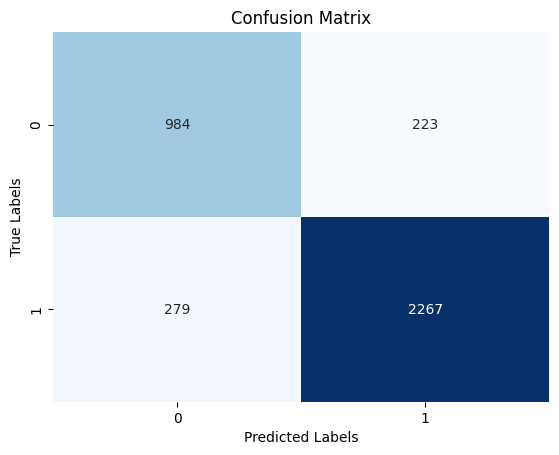

----------------------------------------------------------------------
Accuracy Score:  0.866240341060485
Precision Score:  0.8152444076222038
Recall Score:  0.7790973871733967


In [ ]:
from sklearn import metrics
import seaborn as sns
theta = 0.4
# Print the confusion matrix
predicted = (pred>theta).astype(int)
cm = metrics.confusion_matrix(test_true,  predicted)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print the precision and recall, among other metrics
print('Evaluation Metrics')
print('-'*70)
print("Accuracy Score: ",metrics.accuracy_score(test_true,  predicted))
print("Precision Score: ",metrics.precision_score(test_true,  predicted))
print("Recall Score: ",metrics.recall_score(test_true,  predicted))

In [ ]:
import pickle

pickle.dump(model, open(base_dir+MODEL_NAME+'.pkl', 'wb'))